In [49]:
%matplotlib inline
import numpy as np
import cosmolopy
from fancy_plot import *
import inspect 
import scipy
from scipy.stats import lognorm, norm
import time
import sys
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit


# Conversion Factors
Mpc_to_cm = 3.086e+24
erg_to_GeV = 624.151

# StarFormationHistory (SFR), from Hopkins and Beacom 2006, unit = M_sun/yr/Mpc^3 
@np.vectorize
def HopkinsBeacom2006StarFormationRate(z):
    x = np.log10(1.+z)
    if x<0.30963:
        return np.power(10,3.28*x-1.82)
    if (x>=0.30963)and(x<0.73878):
        return np.power(10,-0.26*x-0.724)
    if x>=0.73878:
        return np.power(10,-8.0*x+4.99)

# Conversion factor b used to convert the source flux into an average number of neutrinos in the detector
def calc_conversion_factor(z, Gamma, Phi0): 
    
    u_lim=1e9/(1+z) ## upper IceCube range
    l_lim=1e2/(1+z) ## lower IceCube range

    if Gamma!=2.0:
        exponent=(2-Gamma)
        nenner=1/exponent*(u_lim**exponent-l_lim**exponent)

    else:
        nenner=(np.log(u_lim)-np.log(l_lim))
        
    # NumberofSigEvents(self._Gamma) 
    # Number of Signal Events for the whole livetime, should be estimated from Phi0, Gamma
    nsig = 512    ## Just a Guess for now
    return nsig/Phi0*(1/(1e5)**Gamma)*1/(nenner)

# Calculate the number of sources in volume and luminosity interval
def calc_dN(LF,logL,z0, logLbinwidth, zbinwidth, dgamma=1):
    LF_val=LF(z0,logL)
    return LF_val*cosmolopy.distance.diff_comoving_volume(z,**cosmology)*logLbinwidth*zbinwidth*dgamma

Hopkins_norm = scipy.integrate.quad(lambda z: HopkinsBeacom2006StarFormationRate(z), 0, 10)[0]

# Settings

In [28]:
# Physics Settings

density = 1*1e-7 ## 1/Mpc^3
L_nu = 4*1e50
gamma_range = [2.19] # in the original code I also integrated over gamma for some source count distributions, therefore its an array
phi0 = 1.01*1e-18

cosmology = {'omega_M_0' : 0.308, 'omega_lambda_0' : 0.692, 'h' : 0.678}
cosmology = cosmolopy.distance.set_omega_k_0(cosmology) #Flat universe

### Define a Luminosity Function
LF = lambda z, logL:density*HopkinsBeacom2006StarFormationRate(z)/Hopkins_norm*\
                    np.log(10)*10**logL*lognorm.pdf(10**logL, 1, scale = L_nu)

In [73]:
# Integration Parameters 

logMu_range=[-10,6]        # expected range in log mu, 
N_Mu_bins=2000             # number of bins for log nu histogram

z_limits = [0.04, 7.]     # Redshift limits
nzbins=600                 # number of z bins

Lum_limits = [1e48,1e53]   # Luminosity limits 
nLbins=600                 # number of logLuminosity bins

# Example 'Time needed for 600x600 bins: 238s'

# Luminosity Distribution

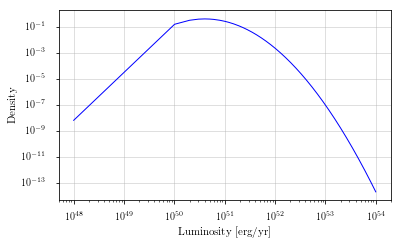

In [74]:
##use Scipy Lognormal Distribution https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html

fig, ax = newfig(0.9)
L = np.linspace(1e48, 1e54, 10000)
ax.loglog(L, L*lognorm.pdf(L, 1, scale = L_nu), color = 'blue')
ax.set_xlabel('Luminosity [erg/yr]')
ax.set_ylabel('Density')
plt.grid(True)
plt.show()

# HopkinsBeacom2006StarFormationRate

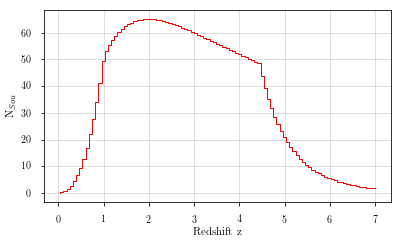

In [75]:
plot_bins = 100
z = np.linspace(z_limits[0], z_limits[1], plot_bins)
dz=(float(z_limits[1])-float(z_limits[0]))/plot_bins
fig, ax = newfig(0.9)
ax.plot(z, density*HopkinsBeacom2006StarFormationRate(z)/Hopkins_norm*\
           cosmolopy.distance.diff_comoving_volume(z,**cosmology)*dz, drawstyle='steps-pre')
ax.set_xlabel('Redshift z')
ax.set_ylabel(r'N$_{Sou}$')  ##Sources per redshift interval
plt.grid(True)
plt.show()

# Comoving Volume

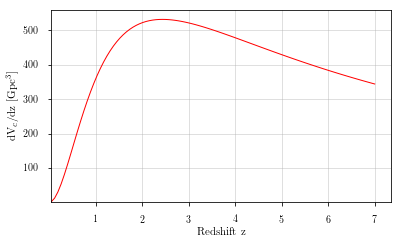

In [76]:
fig, ax = newfig(0.9)
diff_distance = cosmolopy.distance.diff_comoving_volume(z,**cosmology)*4*np.pi/(1000)**3
ax.plot(z, diff_distance )
plt.grid(True)
ax.set_xlabel('Redshift z')
ax.set_ylabel('dV$_c$/dz [Gpc$^3$]')
ax.set_xlim(z[0])
ax.set_ylim(np.min(diff_distance))
plt.show()

# Luminosity Function 2D Plot

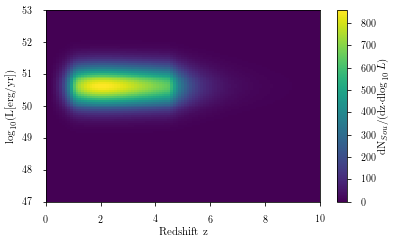

In [77]:
z = np.linspace(0, 10, 100)
log10L = np.linspace(47, 53, 100)
X,Y = np.meshgrid(z, log10L)

plt_func= lambda z,log10L : LF(z, log10L)*cosmolopy.distance.diff_comoving_volume(z,**cosmology)
Z = plt_func(X,Y)

fig, ax = newfig(0.9)
p = ax.pcolor(X, Y, Z)
cb = fig.colorbar(p, label = 'dN$_{Sou}$/(dz$\cdot$d$\log_{10}L)$')
ax.set_xlabel(r'Redshift z')
ax.set_ylabel(r'$\log_{10}$(L[erg/yr])')
plt.show()

# Integration Procedure

In [78]:
flux_mode = False

# Setup Arrays

logMu_array=np.linspace(logMu_range[0],logMu_range[1],N_Mu_bins)

Flux_from_fixed_z=[]

dmu=[(float(10**logMu_array[i+1])-float(10**logMu_array[i])) for i in range(len(logMu_array)-1)]
dlogmu=float((logMu_range[1]-logMu_range[0]))/N_Mu_bins

zs=np.linspace(z_limits[0],z_limits[1],nzbins)
deltaz=(float(z_limits[1])-float(z_limits[0]))/nzbins

Ls=np.linspace(np.log10(Lum_limits[0]),np.log10(Lum_limits[1]),nLbins)
deltaL=(np.log10(Lum_limits[1])-np.log10(Lum_limits[0]))/nLbins


# Integration

t0=time.time()
if len(gamma_range)==1:
    gamma_ran=gamma_range
    dgamma=1
elif len(gamma_range)==2:
    gamma_ran=np.linspace(gamma_range[0],gamma_range[1],ngamma_bins)
    dgamma=(gamma_range[1]-gamma_range[0])/ngamma_bins
else:
    print "Only 1 or 2 values make sens for the spectral index range of the source"

N_Ges=0
Count_array=np.zeros(N_Mu_bins)
muError=[]
tot_bins = nLbins * nzbins
print('Starting Integration...Going to evaluate {} bins'.format(tot_bins))
for gam_c, gam in enumerate(gamma_ran):
    Flux_from_fixed_z.append([])
    print "-"*20
    
    # Loop over redshift bins
    for z_count, z in enumerate(zs[:-1]):
        bz=calc_conversion_factor(z, gam, phi0) # Conversion Factor for given z
        dlz=cosmolopy.distance.luminosity_distance(z, **cosmology) # Luminosity Distance
        tot_flux_from_z=0.
        
        # Loop over Luminosity bins
        for l_count, lum in enumerate(Ls[:-1]): 
            run_id = z_count*nLbins+l_count
            if run_id%(tot_bins/10)==0.:
                print "{}%".format(100*run_id/tot_bins)
            # Number of Sources in 
            dN=calc_dN(LF, lum, z, deltaL, deltaz, dgamma)*\
                      (2*np.pi*(1-np.cos(np.radians(95)))) # Last Factor: Only Northern Hemisphere
            N_Ges+=dN 
            if flux_mode==True: bz=1
            #Flux to Source Strength
            logmu=np.log10(erg_to_GeV*10**lum/(np.pi*1e7)/(4*np.pi*(Mpc_to_cm*dlz)**2)*bz)
            
            # Add dN to Histogram
            if logmu<logMu_range[1] and logmu>logMu_range[0]:
                tot_flux_from_z+=dN*10**logmu
                Count_array[int((logmu-logMu_range[0])*N_Mu_bins/(logMu_range[1]-logMu_range[0]))]+=dN
            else:
                muError.append(logmu)
                
        Flux_from_fixed_z.append(tot_flux_from_z)


print "Number of Mu out of Range: {}".format(len(muError))
print "Total number of sources {}".format(N_Ges)

t1=time.time()

print "-"*20
print "\n Time needed for {}x{} bins: {}s".format(nzbins,nLbins,int(t1-t0))

Starting Integration...Going to evaluate 360000 bins
--------------------
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
Number of Mu out of Range: 0
Total number of sources 24440.3845008
--------------------

 Time needed for 600x600 bins: 234s


# Plotting

dN/dmu ~ mu^-4.17948403708 (Expected to be around mu^-2.5 for euclidean universe, i.e. nearby sources)


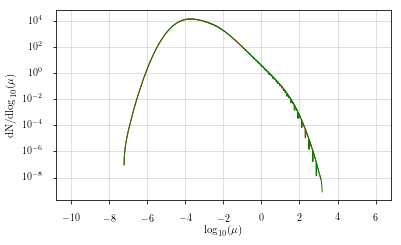

In [79]:
# Plotting

dNdlogmu=np.array(Count_array)/dlogmu
fig, ax = newfig(0.9)
ax.semilogy(logMu_array, dNdlogmu)

##Spline the Histogram
spl = UnivariateSpline([s for t,s in enumerate(logMu_array) if dNdlogmu[t]>0],
                       [s for s in dNdlogmu if s>0],
                       k=1, s=0)

# Fit Tail
popt, pcov = curve_fit(lambda x,a,b: a*x+b,
                       np.linspace(1.5,2.5,100),
                       np.log10(spl(np.linspace(1.5,2.5,100))))

print('dN/dmu ~ mu^{} (Expected to be around mu^-2.5 for euclidean universe, i.e. nearby sources)'.format(popt[0]-1))

ax.semilogy(logMu_array, spl(logMu_array))
ax.set_xlabel(r'$\log_{10}(\mu)$')
ax.set_ylabel(r'dN/d$\log_{10}(\mu)$')
plt.savefig('Source_Count_Distribution.png', dpi=300)
plt.grid(True)
plt.show()

# Rubbish

In [44]:
n_sou = 4*np.pi* \
        scipy.integrate.quad(lambda z: cosmolopy.distance.diff_comoving_volume(z, **cosmology), 0, 10)[0]*\
        density
print 'Tot Number of Sources ~ {}'.format(n_sou)

Tot Number of Sources ~ 376977.313062
